In [2]:
import numpy as np
import pandas as pd

import random
import scipy.stats as st

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
sns.reset_orig()
sns.set_style('white')
mpl.rcParams['pdf.fonttype'] = 42

### Define feature sets

In [3]:
prot_feat_arr = ['Degree','Betweenness','Closeness','Eigenvector',
                 'ClusteringCoeff','Load', 'Pagerank']
print('# Protein-level features (Prot): %s' % len(prot_feat_arr))

res_feat_arr = ['3DLoc_Annot', 'Percent_Degree_Change',
                'Degree_Change','Betweenness_Change','Closeness_Change','Eigenvector_Change',
                'ClusteringCoeff_Change','Load_Change', 'Pagerank_Change']
print('# Residue-level features (Res): %s' % len(res_feat_arr))

net_feat_arr = ['3DLoc_Annot',
                'Degree','Betweenness','Closeness','Eigenvector',
                'ClusteringCoeff','Load', 'Pagerank',
                'Percent_Degree_Change',
                'Degree_Change','Betweenness_Change','Closeness_Change','Eigenvector_Change',
                'ClusteringCoeff_Change','Load_Change', 'Pagerank_Change']
print('# Network-based features (Net=Prot+Res): %s' % len(net_feat_arr))

aa_feat_arr = ['AABLOSUM', 'AACharge', 'AACOSMIC', 'AACOSMICvsHapMap', 'AACOSMICvsSWISSPROT', 'AAEx', 
               'AAGrantham', 'AAHapMap', 'AAHGMD2003', 'AAHydrophobicity', 'AAMJ', 'AAPAM250', 'AAPolarity', 
               'AATransition', 'AATripletFirstDiffProb', 'AATripletFirstProbMut', 'AATripletFirstProbWild', 
               'AATripletSecondDiffProb', 'AATripletSecondProbMut', 'AATripletSecondProbWild', 
               'AATripletThirdDiffProb', 'AATripletThirdProbMut', 'AATripletThirdProbWild', 'AAVB', 'AAVolume', 
               'ExonConservation', 'ExonHapMapSnpDensity', 'ExonSnpDensity', 'HMMEntropy', 'HMMPHC', 
               'HMMRelEntropy', 'MGAEntropy', 'MGAPHC', 'MGARelEntropy', 'PredBFactorF', 'PredBFactorM', 
               'PredBFactorS', 'PredRSAB', 'PredRSAE', 'PredRSAI', 'PredSSC', 'PredSSE', 'PredSSH', 
               'PredStabilityH', 'PredStabilityL', 'PredStabilityM', 'RegCompC', 'RegCompDE', 'RegCompEntropy', 
               'RegCompG', 'RegCompH', 'RegCompILVM', 'RegCompKR', 'RegCompNormEntropy', 'RegCompP', 'RegCompQ', 
               'RegCompWYF', 'UniprotACTSITE', 'UniprotBINDING', 'UniprotCABIND', 'UniprotCARBOHYD', 
               'UniprotCOMPBIAS', 'UniprotDISULFID', 'UniprotDNABIND', 'UniprotDOM_Chrom', 'UniprotDOM_LOC', 
               'UniprotDOM_MMBRBD', 'UniprotDOM_PostModEnz', 'UniprotDOM_PostModRec', 'UniprotDOM_PPI', 
               'UniprotDOM_RNABD', 'UniprotDOM_TF', 'UniprotLIPID', 'UniprotMETAL', 'UniprotMODRES', 
               'UniprotMOTIF', 'UniprotNPBIND', 'UniprotPROPEP', 'UniprotREGIONS', 'UniprotREP', 'UniprotSECYS', 
               'UniprotSIGNAL', 'UniprotSITE', 'UniprotTRANSMEM', 'UniprotZNFINGER']
# Remove these 2 features from aa_feat_arr because they had NaN values for all mutations
aa_feat_arr.remove('UniprotLIPID')
aa_feat_arr.remove('UniprotSECYS')
print('# Classic amino acid features (AA): %s' % len(aa_feat_arr))

tot_feat_arr = net_feat_arr + aa_feat_arr
print('# All features (Net+AA): %s' % len(tot_feat_arr))

# Protein-level features (Prot): 7
# Residue-level features (Res): 9
# Network-based features (Net=Prot+Res): 16
# Classic amino acid features (AA): 83
# All features (Net+AA): 99


### Define positive and negative mutation classes

In [4]:
# Define positive and negative mutation classes
pos, neg = 'Pathogenic', 'Common'

### Define functions

In [5]:
def get_classifier_performance_CV(df, train_idx, test_idx, feat_arr):
    
    # Create classifier
    clf = RandomForestClassifier(n_estimators=1000, max_features='sqrt', random_state=0, n_jobs=-1)

    # Get feature values (X) and the correct class labels (y)
    X = df[feat_arr].values
    y = [1 if mut==pos else 0 for mut in df['Mut_type'].values]
    
    # Set up a custom iterable for CV splits
    custom_cv = zip(train_idx, test_idx)
    
    # Get prediction scores of test sets of each CV iteration
    y_pred_proba = cross_val_predict(clf, X, y, cv=custom_cv, method='predict_proba')
    
    return y_pred_proba[:,1]

In [6]:
def get_pred_interface(df, y_preds):
    # Extract indices of interface mutations
    inter_idx = df[(df['3DLoc_Annot']>0)&(df['3DLoc_Annot']<1)].index
    y_preds = y_preds[inter_idx]
    
    # Get the correct class labels (y)
    y = [1 if mut==pos else 0 for mut in df['Mut_type'].values]
    y = list(np.array(y)[inter_idx])
    
    # Return class labels and prediction scores of interface mutations only
    return (y, y_preds)

In [7]:
def plot_roc_all_and_interface(y_srn, y_preds_prot_srn, y_preds_res_srn, y_preds_net_srn,
                               y_preds_aa_srn, y_preds_res_aa_srn, y_preds_net_aa_srn,
                               y_int_srn, y_preds_prot_int_srn, y_preds_res_int_srn, y_preds_net_int_srn,
                               y_preds_aa_int_srn, y_preds_res_aa_int_srn, y_preds_net_aa_int_srn,
                               y_ext, y_preds_prot_ext, y_preds_res_ext, y_preds_net_ext,
                               y_preds_aa_ext, y_preds_res_aa_ext, y_preds_net_aa_ext,
                               y_int_ext, y_preds_prot_int_ext, y_preds_res_int_ext, y_preds_net_int_ext,
                               y_preds_aa_int_ext, y_preds_res_aa_int_ext, y_preds_net_aa_int_ext,
                               fig_outfile):

    fig = plt.figure(figsize=(6.6, 2.34))

    ax = plt.subplot(1, 3, 1)

    fpr, tpr, threshold = metrics.roc_curve(y_srn, y_preds_prot_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'lightgreen', label = 'Prot = %0.3f' % auc, linewidth=1) #lightgreen
    
    fpr, tpr, threshold = metrics.roc_curve(y_srn, y_preds_res_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#fdbf6f', label = 'Res = %0.3f' % auc, linewidth=1) #lightpink
    
    fpr, tpr, threshold = metrics.roc_curve(y_srn, y_preds_net_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#a6cee3', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue
    
    fpr, tpr, threshold = metrics.roc_curve(y_ext, y_preds_prot_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#33a02c', label = 'Prot = %0.3f' % auc, linewidth=1) #lightgreen
    
    fpr, tpr, threshold = metrics.roc_curve(y_ext, y_preds_res_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#ff7f00', label = 'Res = %0.3f' % auc, linewidth=1) #lightpink
    
    fpr, tpr, threshold = metrics.roc_curve(y_ext, y_preds_net_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#1f78b4', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    plt.legend(loc = 'lower right')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.xticks((0,0.2,0.4,0.6,0.8,1)); plt.yticks((0,0.2,0.4,0.6,0.8,1))
    plt.title('Network features', fontsize=9)
    
    ax = plt.subplot(1, 3, 2)

    fpr, tpr, threshold = metrics.roc_curve(y_srn, y_preds_net_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#a6cee3', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    fpr, tpr, threshold = metrics.roc_curve(y_srn, y_preds_aa_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'lightgray', label = 'AA = %0.3f' % auc, linewidth=1) #lightgray
    
    fpr, tpr, threshold = metrics.roc_curve(y_srn, y_preds_res_aa_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'plum', label = 'Res & AA = %0.3f' % auc, linewidth=1) #peachpuff
    
    fpr, tpr, threshold = metrics.roc_curve(y_srn, y_preds_net_aa_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'chocolate', label = 'Net & AA = %0.3f' % auc, linewidth=2) #indianred
    
    fpr, tpr, threshold = metrics.roc_curve(y_ext, y_preds_net_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#1f78b4', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    fpr, tpr, threshold = metrics.roc_curve(y_ext, y_preds_aa_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'gray', label = 'AA = %0.3f' % auc, linewidth=1) #lightgray
    
    fpr, tpr, threshold = metrics.roc_curve(y_ext, y_preds_res_aa_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'mediumorchid', label = 'Res & AA = %0.3f' % auc, linewidth=1) #peachpuff
    
    fpr, tpr, threshold = metrics.roc_curve(y_ext, y_preds_net_aa_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'saddlebrown', label = 'Net & AA = %0.3f' % auc, linewidth=2) #indianred

    plt.legend(loc = 'lower right')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.xticks((0,0.2,0.4,0.6,0.8,1)); plt.yticks((0,0.2,0.4,0.6,0.8,1))
    plt.title('Network and AA features', fontsize=9)
    
    ax = plt.subplot(1, 3, 3)
    
    fpr, tpr, threshold = metrics.roc_curve(y_int_srn, y_preds_prot_int_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'lightgreen', label = 'Prot = %0.3f' % auc, linewidth=1) #lightgreen  
    
    fpr, tpr, threshold = metrics.roc_curve(y_int_srn, y_preds_res_int_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#fdbf6f', label = 'Res = %0.3f' % auc, linewidth=1) #lightpink
    
    fpr, tpr, threshold = metrics.roc_curve(y_int_srn, y_preds_net_int_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#a6cee3', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    fpr, tpr, threshold = metrics.roc_curve(y_int_srn, y_preds_aa_int_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'lightgray', label = 'AA = %0.3f' % auc, linewidth=1)  #lightgray
    
    fpr, tpr, threshold = metrics.roc_curve(y_int_srn, y_preds_res_aa_int_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'plum', label = 'Res & AA = %0.3f' % auc, linewidth=1) #peachpuff
    
    fpr, tpr, threshold = metrics.roc_curve(y_int_srn, y_preds_net_aa_int_srn, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'chocolate', label = 'Net & AA = %0.3f' % auc, linewidth=2) #indianred
    
    fpr, tpr, threshold = metrics.roc_curve(y_int_ext, y_preds_prot_int_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#33a02c', label = 'Prot = %0.3f' % auc, linewidth=1) #lightgreen  
    
    fpr, tpr, threshold = metrics.roc_curve(y_int_ext, y_preds_res_int_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#ff7f00', label = 'Res = %0.3f' % auc, linewidth=1) #lightpink
    
    fpr, tpr, threshold = metrics.roc_curve(y_int_ext, y_preds_net_int_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, '#1f78b4', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    fpr, tpr, threshold = metrics.roc_curve(y_int_ext, y_preds_aa_int_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'gray', label = 'AA = %0.3f' % auc, linewidth=1)  #lightgray
    
    fpr, tpr, threshold = metrics.roc_curve(y_int_ext, y_preds_res_aa_int_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'mediumorchid', label = 'Res & AA = %0.3f' % auc, linewidth=1) #peachpuff
    
    fpr, tpr, threshold = metrics.roc_curve(y_int_ext, y_preds_net_aa_int_ext, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'saddlebrown', label = 'Net & AA = %0.3f' % auc, linewidth=2) #indianred

    plt.legend(loc = 'lower right')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.xticks((0,0.2,0.4,0.6,0.8,1)); plt.yticks((0,0.2,0.4,0.6,0.8,1))
    plt.title('Interface residues only', fontsize=9)
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=.34)

    plt.savefig(fig_outfile, transparent=True, dpi=300)
    plt.show()

In [27]:
def plot_prc_all_and_interface(y_srn, y_preds_prot_srn, y_preds_res_srn, y_preds_net_srn,
                               y_preds_aa_srn, y_preds_res_aa_srn, y_preds_net_aa_srn,
                               y_int_srn, y_preds_prot_int_srn, y_preds_res_int_srn, y_preds_net_int_srn,
                               y_preds_aa_int_srn, y_preds_res_aa_int_srn, y_preds_net_aa_int_srn,
                               y_ext, y_preds_prot_ext, y_preds_res_ext, y_preds_net_ext,
                               y_preds_aa_ext, y_preds_res_aa_ext, y_preds_net_aa_ext,
                               y_int_ext, y_preds_prot_int_ext, y_preds_res_int_ext, y_preds_net_int_ext,
                               y_preds_aa_int_ext, y_preds_res_aa_int_ext, y_preds_net_aa_int_ext,
                               fig_outfile):

    fig = plt.figure(figsize=(7, 2.34))

    ax = plt.subplot(1, 3, 1)

    pre, rec, thresh = metrics.precision_recall_curve(y_srn, y_preds_prot_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'lightgreen', label = 'Prot = %0.3f' % auc, linewidth=1) #lightgreen
    
    pre, rec, thresh = metrics.precision_recall_curve(y_srn, y_preds_res_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#fdbf6f', label = 'Res = %0.3f' % auc, linewidth=1) #lightpink
    
    pre, rec, thresh = metrics.precision_recall_curve(y_srn, y_preds_net_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#a6cee3', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue
    
    pre, rec, thresh = metrics.precision_recall_curve(y_ext, y_preds_prot_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#33a02c', label = 'Prot = %0.3f' % auc, linewidth=1) #lightgreen
    
    pre, rec, thresh = metrics.precision_recall_curve(y_ext, y_preds_res_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#ff7f00', label = 'Res = %0.3f' % auc, linewidth=1) #lightpink
    
    pre, rec, thresh = metrics.precision_recall_curve(y_ext, y_preds_net_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#1f78b4', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    plt.legend(loc = 'lower right')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.xticks((0,0.2,0.4,0.6,0.8,1)); plt.yticks((0,0.2,0.4,0.6,0.8,1))
    plt.title('Network features', fontsize=9)
    
    ax = plt.subplot(1, 3, 2)

    pre, rec, thresh = metrics.precision_recall_curve(y_srn, y_preds_net_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#a6cee3', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    pre, rec, thresh = metrics.precision_recall_curve(y_srn, y_preds_aa_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'lightgray', label = 'AA = %0.3f' % auc, linewidth=1) #lightgray
    
    pre, rec, thresh = metrics.precision_recall_curve(y_srn, y_preds_res_aa_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'plum', label = 'Res & AA = %0.3f' % auc, linewidth=1) #peachpuff
    
    pre, rec, thresh = metrics.precision_recall_curve(y_srn, y_preds_net_aa_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'chocolate', label = 'Net & AA = %0.3f' % auc, linewidth=2) #indianred
    
    pre, rec, thresh = metrics.precision_recall_curve(y_ext, y_preds_net_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#1f78b4', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    pre, rec, thresh = metrics.precision_recall_curve(y_ext, y_preds_aa_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'gray', label = 'AA = %0.3f' % auc, linewidth=1) #lightgray
    
    pre, rec, thresh = metrics.precision_recall_curve(y_ext, y_preds_res_aa_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'mediumorchid', label = 'Res & AA = %0.3f' % auc, linewidth=1) #peachpuff
    
    pre, rec, thresh = metrics.precision_recall_curve(y_ext, y_preds_net_aa_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'saddlebrown', label = 'Net & AA = %0.3f' % auc, linewidth=2) #indianred

    plt.legend(loc = 'lower right')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.xticks((0,0.2,0.4,0.6,0.8,1)); plt.yticks((0,0.2,0.4,0.6,0.8,1))
    plt.title('Network and AA features', fontsize=9)
    
    ax = plt.subplot(1, 3, 3)
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int_srn, y_preds_prot_int_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'lightgreen', label = 'Prot = %0.3f' % auc, linewidth=1) #lightgreen  
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int_srn, y_preds_res_int_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#fdbf6f', label = 'Res = %0.3f' % auc, linewidth=1) #lightpink
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int_srn, y_preds_net_int_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#a6cee3', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    pre, rec, thresh = metrics.precision_recall_curve(y_int_srn, y_preds_aa_int_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'lightgray', label = 'AA = %0.3f' % auc, linewidth=1)  #lightgray
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int_srn, y_preds_res_aa_int_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'plum', label = 'Res & AA = %0.3f' % auc, linewidth=1) #peachpuff
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int_srn, y_preds_net_aa_int_srn, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'chocolate', label = 'Net & AA = %0.3f' % auc, linewidth=2) #indianred
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int_ext, y_preds_prot_int_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#33a02c', label = 'Prot = %0.3f' % auc, linewidth=1) #lightgreen  
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int_ext, y_preds_res_int_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#ff7f00', label = 'Res = %0.3f' % auc, linewidth=1) #lightpink
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int_ext, y_preds_net_int_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, '#1f78b4', label = 'Net = %0.3f' % auc, linewidth=1) #lightblue

    pre, rec, thresh = metrics.precision_recall_curve(y_int_ext, y_preds_aa_int_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'gray', label = 'AA = %0.3f' % auc, linewidth=1)  #lightgray
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int_ext, y_preds_res_aa_int_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'mediumorchid', label = 'Res & AA = %0.3f' % auc, linewidth=1) #peachpuff
    
    pre, rec, thresh = metrics.precision_recall_curve(y_int_ext, y_preds_net_aa_int_ext, pos_label=1)
    auc = metrics.auc(rec, pre)
    ax.plot(rec, pre, 'saddlebrown', label = 'Net & AA = %0.3f' % auc, linewidth=2) #indianred

    plt.legend(loc = 'lower right')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.xticks((0,0.2,0.4,0.6,0.8,1)); plt.yticks((0,0.2,0.4,0.6,0.8,1))
    plt.title('Interface residues only', fontsize=9)
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=.34)

    plt.savefig(fig_outfile, transparent=True, dpi=300)
    plt.show()

## Read training set for Pathogenic vs Neutral Variants using SRNet
#### All feature values are normalized

In [9]:
# read normalized features
total_df_norm = pd.read_table('../data/SRNet_germline_features_all_norm.txt')
print(total_df_norm.shape)
print('# pathogenic variants: %s' % len(total_df_norm[total_df_norm['Mut_type']==pos]))
print('# neutral variants: %s' % len(total_df_norm[total_df_norm['Mut_type']==neg]))
print('# all variants: %s' % len(total_df_norm))
total_df_norm.head()

(9026, 106)
# pathogenic variants: 5608
# neutral variants: 3418
# all variants: 9026


,Index,Mut_type,UID,Unip,Accession,Res,AA_Change,3DLoc_Annot,Degree,Betweenness,...,UniprotMODRES,UniprotMOTIF,UniprotNPBIND,UniprotPROPEP,UniprotREGIONS,UniprotREP,UniprotSIGNAL,UniprotSITE,UniprotTRANSMEM,UniprotZNFINGER
0,0,Pathogenic,2,Q30201,NM_000410,282,C282Y,1.608854,-0.448554,-0.255884,...,-0.085164,-0.076118,-0.131742,-0.043437,2.134,-0.261797,-0.010526,-0.063277,-0.088403,-0.070782
1,1,Pathogenic,3,Q30201,NM_000410,63,H63D,-1.010940,-0.448554,-0.255884,...,-0.085164,-0.076118,-0.131742,-0.043437,2.134,-0.261797,-0.010526,-0.063277,-0.088403,-0.070782
2,2,Pathogenic,4,Q30201,NM_000410,105,I105T,1.608854,-0.448554,-0.255884,...,-0.085164,-0.076118,-0.131742,-0.043437,2.134,-0.261797,-0.010526,-0.063277,-0.088403,-0.070782
3,3,Pathogenic,5,Q30201,NM_000410,93,G93R,0.298957,-0.448554,-0.255884,...,-0.085164,-0.076118,-0.131742,-0.043437,2.134,-0.261797,-0.010526,-0.063277,-0.088403,-0.070782
4,4,Pathogenic,6,Q30201,NM_000410,127,Q127H,-1.010940,-0.448554,-0.255884,...,-0.085164,-0.076118,-0.131742,-0.043437,2.134,-0.261797,-0.010526,-0.063277,-0.088403,-0.070782


### Set up 5-fold gene holdout Cross-Validation (CV)

In [10]:
# Set seed=1 for the random.shuffle() function for a reproducible shuffled output 

# Get a list of all proteins
unip_arr = list(np.unique(total_df_norm['Unip'].values))
print(len(unip_arr), unip_arr[:5])

# Get a list of proteins with driver mutations
driver_unip_arr = list(np.unique(total_df_norm[total_df_norm['Mut_type']==pos]['Unip'].values))
# Get a list of proteins with passenger mutations
passenger_unip_arr = list(np.unique(total_df_norm[total_df_norm['Mut_type']==neg]['Unip'].values))
print(len(driver_unip_arr), len(passenger_unip_arr))

# Get a list of proteins with both driver and passenger mutations
double_arr = list()
for unip in driver_unip_arr:
    if unip in passenger_unip_arr:
        double_arr.append(unip)
print(len(double_arr), double_arr[:5])

# Get a list of proteins with only passenger mutations
passenger_unip_arr_2 = [unip for unip in passenger_unip_arr if unip not in driver_unip_arr]
print(len(passenger_unip_arr_2), passenger_unip_arr_2[:5])

# Shuffle the list of proteins with driver mutations (they have passenger mutations too)
driver_unip_arr_shuffled = list(driver_unip_arr)
random.seed(1)
random.shuffle(driver_unip_arr_shuffled)

# Shuffle the list of proteins with only passenger mutations
passenger_unip_arr_shuffled = list(passenger_unip_arr_2)
random.seed(1)
random.shuffle(passenger_unip_arr_shuffled)

1342 ['D3W0D1', 'O00141', 'O00148', 'O00170', 'O00187']
603 1037
298 ['O00170', 'O00187', 'O00189', 'O00238', 'O00300']
739 ['D3W0D1', 'O00141', 'O00148', 'O00194', 'O00206']


In [11]:
# Split the list of driver and passenger proteins into 5 folds for 5-fold CV
driver_unip_arr_split = np.array_split(np.array(driver_unip_arr_shuffled),5)
passenger_unip_arr_split = np.array_split(np.array(passenger_unip_arr_shuffled),5)

# Get indices of training and test sets for each CV iteration
train_idx, test_idx = list(), list()
for i in np.arange(0,5):
    # Arrange 1 fold to be the test set
    unip_arr_test = list(driver_unip_arr_split[i])+list(passenger_unip_arr_split[i])
    # Arrange remaining 4 folds to be the training set
    unip_arr_train = list()
    for unip in unip_arr:
        if unip not in unip_arr_test:
            unip_arr_train.append(unip)
    train_df_norm = total_df_norm[total_df_norm['Unip'].isin(unip_arr_train)].copy()
    test_df_norm = total_df_norm[total_df_norm['Unip'].isin(unip_arr_test)].copy()
    train_idx.append(list(train_df_norm.index))
    test_idx.append(list(test_df_norm.index))

### Get 5-fold CV results for each feature set

In [12]:
y_srn = [1 if mut==pos else 0 for mut in total_df_norm['Mut_type'].values]

In [13]:
y_preds_prot_srn = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, prot_feat_arr)
y_preds_res_srn = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, res_feat_arr)
y_preds_net_srn = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, net_feat_arr)
y_preds_aa_srn = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, aa_feat_arr)
y_preds_res_aa_srn = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, aa_feat_arr+res_feat_arr)
y_preds_net_aa_srn = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, tot_feat_arr)

In [14]:
y_int_srn, y_preds_prot_int_srn = get_pred_interface(total_df_norm, y_preds_prot_srn)
y_int_srn, y_preds_res_int_srn = get_pred_interface(total_df_norm, y_preds_res_srn)
y_int_srn, y_preds_net_int_srn = get_pred_interface(total_df_norm, y_preds_net_srn)
y_int_srn, y_preds_aa_int_srn = get_pred_interface(total_df_norm, y_preds_aa_srn)
y_int_srn, y_preds_res_aa_int_srn = get_pred_interface(total_df_norm, y_preds_res_aa_srn)
y_int_srn, y_preds_net_aa_int_srn = get_pred_interface(total_df_norm, y_preds_net_aa_srn)

## Read training set for Pathogenic vs Neutral Variants using ExtNet
#### All feature values are normalized

### All mutations

In [15]:
# read normalized features
total_df_norm = pd.read_table('../data/ExtNet_germline_features_all_norm.txt')
print(total_df_norm.shape)
print('# pathogenic variants: %s' % len(total_df_norm[total_df_norm['Mut_type']==pos]))
print('# neutral variants: %s' % len(total_df_norm[total_df_norm['Mut_type']==neg]))
print('# all variants: %s' % len(total_df_norm))
total_df_norm.head()

(57341, 106)
# pathogenic variants: 21819
# neutral variants: 35522
# all variants: 57341


,Index,Mut_type,UID,Unip,Accession,Res,AA_Change,3DLoc_Annot,Degree,Betweenness,...,UniprotMODRES,UniprotMOTIF,UniprotNPBIND,UniprotPROPEP,UniprotREGIONS,UniprotREP,UniprotSIGNAL,UniprotSITE,UniprotTRANSMEM,UniprotZNFINGER
0,0,Pathogenic,2,Q30201,NM_000410,282,C282Y,1.38519,-0.340104,-0.250668,...,-0.062201,-0.054207,-0.074203,-0.073487,2.884014,-0.214755,-0.077687,-0.033164,-0.202931,-0.100201
1,1,Pathogenic,4,Q30201,NM_000410,105,I105T,1.38519,-0.340104,-0.250668,...,-0.062201,-0.054207,-0.074203,-0.073487,2.884014,-0.214755,-0.077687,-0.033164,-0.202931,-0.100201
2,2,Pathogenic,5,Q30201,NM_000410,93,G93R,0.28271,-0.340104,-0.250668,...,-0.062201,-0.054207,-0.074203,-0.073487,2.884014,-0.214755,-0.077687,-0.033164,-0.202931,-0.100201
3,3,Pathogenic,8,Q30201,NM_000410,283,Q283P,-0.81977,-0.340104,-0.250668,...,-0.062201,-0.054207,-0.074203,-0.073487,2.884014,-0.214755,-0.077687,-0.033164,-0.202931,-0.100201
4,4,Pathogenic,9,Q9P2L0,NM_001006657,626,E626G,-0.81977,-0.496147,-0.256468,...,-0.062201,-0.054207,-0.074203,-0.073487,-0.346733,-0.214755,-0.077687,-0.033164,-0.202931,-0.100201


### Set up 5-fold gene holdout Cross-Validation (CV)

In [16]:
# Set seed=1 for the random.shuffle() function for a reproducible shuffled output 

# Get a list of all proteins
unip_arr = list(np.unique(total_df_norm['Unip'].values))
print(len(unip_arr), unip_arr[:5])

# Get a list of proteins with driver mutations
driver_unip_arr = list(np.unique(total_df_norm[total_df_norm['Mut_type']==pos]['Unip'].values))
# Get a list of proteins with passenger mutations
passenger_unip_arr = list(np.unique(total_df_norm[total_df_norm['Mut_type']==neg]['Unip'].values))
print(len(driver_unip_arr), len(passenger_unip_arr))

# Get a list of proteins with both driver and passenger mutations
double_arr = list()
for unip in driver_unip_arr:
    if unip in passenger_unip_arr:
        double_arr.append(unip)
print(len(double_arr), double_arr[:5])

# Get a list of proteins with only passenger mutations
passenger_unip_arr_2 = [unip for unip in passenger_unip_arr if unip not in driver_unip_arr]
print(len(passenger_unip_arr_2), passenger_unip_arr_2[:5])

# Shuffle the list of proteins with driver mutations (they have passenger mutations too)
driver_unip_arr_shuffled = list(driver_unip_arr)
random.seed(1)
random.shuffle(driver_unip_arr_shuffled)

# Shuffle the list of proteins with only passenger mutations
passenger_unip_arr_shuffled = list(passenger_unip_arr_2)
random.seed(1)
random.shuffle(passenger_unip_arr_shuffled)

8024 ['A0AV96', 'A0AVI4', 'A0AVK6', 'A0AVT1', 'A0JNW5']
2243 7473
1692 ['A2RRP1', 'A6NHR9', 'B1AK53', 'D6RGH6', 'O00148']
5781 ['A0AV96', 'A0AVI4', 'A0AVK6', 'A0AVT1', 'A0JNW5']


In [17]:
# Split the list of driver and passenger proteins into 5 folds for 5-fold CV
driver_unip_arr_split = np.array_split(np.array(driver_unip_arr_shuffled),5)
passenger_unip_arr_split = np.array_split(np.array(passenger_unip_arr_shuffled),5)

# Get indices of training and test sets for each CV iteration
train_idx, test_idx = list(), list()
for i in np.arange(0,5):
    # Arrange 1 fold to be the test set
    unip_arr_test = list(driver_unip_arr_split[i])+list(passenger_unip_arr_split[i])
    # Arrange remaining 4 folds to be the training set
    unip_arr_train = list()
    for unip in unip_arr:
        if unip not in unip_arr_test:
            unip_arr_train.append(unip)
    train_df_norm = total_df_norm[total_df_norm['Unip'].isin(unip_arr_train)].copy()
    test_df_norm = total_df_norm[total_df_norm['Unip'].isin(unip_arr_test)].copy()
    train_idx.append(list(train_df_norm.index))
    test_idx.append(list(test_df_norm.index))

### Get 5-fold CV results for each feature set

In [18]:
y_ext = [1 if mut==pos else 0 for mut in total_df_norm['Mut_type'].values]

In [19]:
y_preds_prot_ext = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, prot_feat_arr)
y_preds_res_ext = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, res_feat_arr)
y_preds_net_ext = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, net_feat_arr)
y_preds_aa_ext = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, aa_feat_arr)
y_preds_res_aa_ext = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, aa_feat_arr+res_feat_arr)
y_preds_net_aa_ext = get_classifier_performance_CV(total_df_norm, train_idx, test_idx, tot_feat_arr)

In [20]:
y_int_ext, y_preds_prot_int_ext = get_pred_interface(total_df_norm, y_preds_prot_ext)
y_int_ext, y_preds_res_int_ext = get_pred_interface(total_df_norm, y_preds_res_ext)
y_int_ext, y_preds_net_int_ext = get_pred_interface(total_df_norm, y_preds_net_ext)
y_int_ext, y_preds_aa_int_ext = get_pred_interface(total_df_norm, y_preds_aa_ext)
y_int_ext, y_preds_res_aa_int_ext = get_pred_interface(total_df_norm, y_preds_res_aa_ext)
y_int_ext, y_preds_net_aa_int_ext = get_pred_interface(total_df_norm, y_preds_net_aa_ext)

In [21]:
mpl.rc('figure', titlesize=10)
mpl.rc('xtick', labelsize=7)
mpl.rc('ytick', labelsize=7)
mpl.rc('legend', fontsize=6)
mpl.rc('axes', labelsize=8)

### Figure 8

In the following plot, lighter colors (top legends) display auROC results using SRNet,
while darker colors (bottom legends) display auROC results using ExtNet.

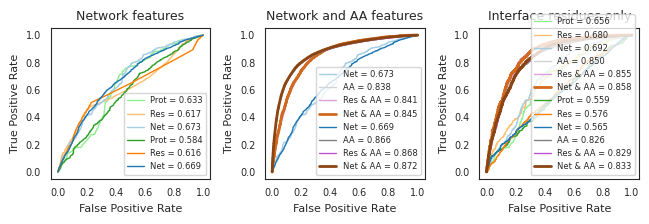

In [22]:
plot_roc_all_and_interface(y_srn, y_preds_prot_srn, y_preds_res_srn, y_preds_net_srn,
                               y_preds_aa_srn, y_preds_res_aa_srn, y_preds_net_aa_srn,
                               y_int_srn, y_preds_prot_int_srn, y_preds_res_int_srn, y_preds_net_int_srn,
                               y_preds_aa_int_srn, y_preds_res_aa_int_srn, y_preds_net_aa_int_srn,
                               y_ext, y_preds_prot_ext, y_preds_res_ext, y_preds_net_ext,
                               y_preds_aa_ext, y_preds_res_aa_ext, y_preds_net_aa_ext,
                               y_int_ext, y_preds_prot_int_ext, y_preds_res_int_ext, y_preds_net_int_ext,
                               y_preds_aa_int_ext, y_preds_res_aa_int_ext, y_preds_net_aa_int_ext,
                               '../out/figures/Fig8.pdf')

### Figure S5

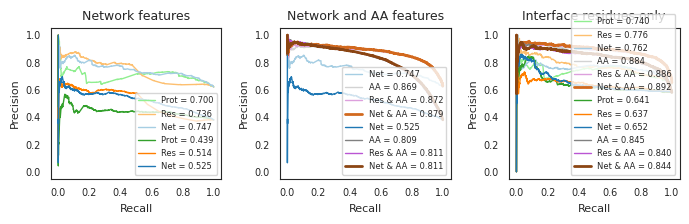

In [28]:
plot_prc_all_and_interface(y_srn, y_preds_prot_srn, y_preds_res_srn, y_preds_net_srn,
                               y_preds_aa_srn, y_preds_res_aa_srn, y_preds_net_aa_srn,
                               y_int_srn, y_preds_prot_int_srn, y_preds_res_int_srn, y_preds_net_int_srn,
                               y_preds_aa_int_srn, y_preds_res_aa_int_srn, y_preds_net_aa_int_srn,
                               y_ext, y_preds_prot_ext, y_preds_res_ext, y_preds_net_ext,
                               y_preds_aa_ext, y_preds_res_aa_ext, y_preds_net_aa_ext,
                               y_int_ext, y_preds_prot_int_ext, y_preds_res_int_ext, y_preds_net_int_ext,
                               y_preds_aa_int_ext, y_preds_res_aa_int_ext, y_preds_net_aa_int_ext,
                               '../out/figures/FigS5.pdf')